In [2]:
%pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings('ignore')

from darts.models import TCNModel
from darts.metrics import mape, mae
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MeanAbsolutePercentageError
from darts.utils.likelihood_models import QuantileRegression

# import optuna
# from optuna.integration import PyTorchLightningPruningCallback
# from optuna.visualization import (
#     plot_optimization_history,
#     plot_contour,
#     plot_param_importances,
# )

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_parquet('/content/drive/MyDrive/TimeSeries/Mittelbuenden/train.parquet')
data['Date'] = pd.to_datetime(data['Date'], utc=True)
data.set_index('Date', inplace=True)
# # data = data.resample('H').sum(min_count=1)
# data = data.resample('D').sum(min_count=1)
data=data.sort_index()
data['Covid'] = 0
data.loc[(data.index >= '2020-02-01') & (data.index <= '2021-06-01'), 'Covid'] = 1
TEST_END = '2022-09-01'
TRAIN_END = '2021-09-01'
TRAIN_END = pd.to_datetime(TRAIN_END)
data = data.loc[data.index < TEST_END]
# data['TimeIndex'] = np.arange(len(data))
# data = data.drop(columns=['TimeIndex'])
data

Consumption  Temperature  Covid
Date                                                        
2018-01-01 00:00:00+00:00  437079.017331     4.191667      0
2018-01-02 00:00:00+00:00  441247.012018     2.158333      0
2018-01-03 00:00:00+00:00  428372.492620     2.604167      0
2018-01-04 00:00:00+00:00  432217.202020     1.508333      0
2018-01-05 00:00:00+00:00  410469.442938     3.991667      0
...                                  ...          ...    ...
2022-08-27 00:00:00+00:00  161911.593064    18.858333      0
2022-08-28 00:00:00+00:00  149582.829196    19.729167      0
2022-08-29 00:00:00+00:00  162369.865901    20.904167      0
2022-08-30 00:00:00+00:00  164082.904566    21.525000      0
2022-08-31 00:00:00+00:00  170114.586732    17.341667      0

[1704 rows x 3 columns]

Data

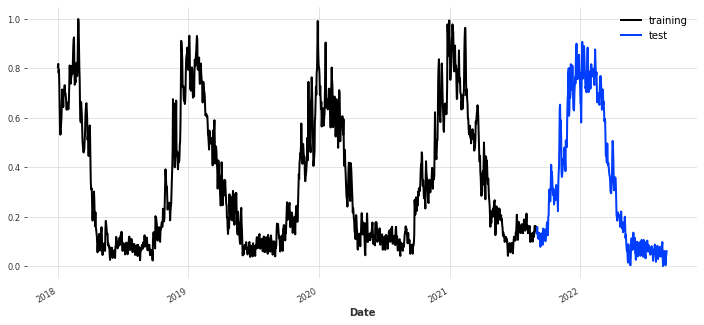

In [6]:
# from sklearn import preprocessing
# series_scaler = Scaler(scaler=preprocessing.StandardScaler())
series_scaler = Scaler()
series = TimeSeries.from_dataframe(df=data, value_cols='Consumption')
series_unsc = series
series = series_scaler.fit_transform(series)

# train, test = series[0:-365], series[-365-730:]
# train_unsc, test_unsc = series_unsc[0:-365], series_unsc[-365-730:]

train, test = series.split_before(TRAIN_END)
train_unsc, test_unsc = series_unsc.split_before(TRAIN_END)

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
test.plot(label='test')
plt.legend()

Covariates

Text(0.5, 1.0, 'Covariates (Covid)')

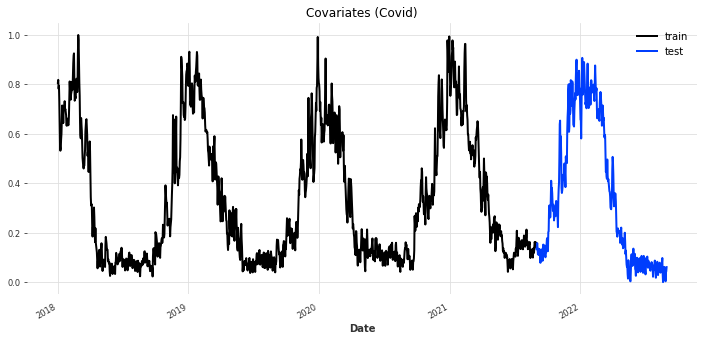

In [7]:
covid = TimeSeries.from_dataframe(df=data, value_cols='Covid')
covid = covid[1:] # it's somehow longer than the others
year = datetime_attribute_timeseries(series, attribute="year")
month = datetime_attribute_timeseries(series, attribute="month", cyclic=True)
weekday = datetime_attribute_timeseries(series, attribute="weekday", cyclic=True)
dayofyear = datetime_attribute_timeseries(series, attribute="dayofyear", cyclic=True)
temperature = TimeSeries.from_dataframe(df=data, value_cols='Temperature')

past_scaler = Scaler()


### future and past
past_covariates = temperature.stack(dayofyear).stack(year).stack(month).stack(weekday)#.stack(covid)
past_covariates = past_scaler.fit_transform(past_covariates)


plt.figure(101, figsize=(12, 5))
# past_covariates.plot()
train.plot(label='train')
test.plot(label='test')
plt.title("Covariates (Covid)")

Follow this: https://unit8co.github.io/darts/userguide/hyperparameter_optimization.html?highlight=tuning

In [ ]:
import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping

from darts.metrics import smape

QUANTILES = [0.01, 0.5, 0.99]
# define objective function
def objective(trial):
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    num_filters = trial.suggest_int("num_filters", 1, 5)
    dilation_base = trial.suggest_int("dilation_base", 2, 4)
    # dropout = trial.suggest_float("dropout", 0.0, 0.4)
    num_layers = trial.suggest_int("num_layers", 1, 2)

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    callbacks = [early_stopper]
    pl_trainer_kwargs = {"callbacks": callbacks}

    # reproducibility
    torch.manual_seed(16)

    # model
    model = TCNModel(
        input_chunk_length=365*2,
        output_chunk_length=365,
        kernel_size=kernel_size,
        num_filters=num_filters,
        weight_norm =True, 
        dilation_base =dilation_base,
        num_layers =num_layers ,
        dropout=0.1, #dropout,
        optimizer_kwargs={'lr': lr},
        likelihood=QuantileRegression(quantiles=QUANTILES), 
        random_state = 16,
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="testModel",
        force_reset=True,
        save_checkpoints=True,
      )


    model.fit(series=train,
        past_covariates=past_covariates,
        val_series=test,
        val_past_covariates=past_covariates,
        epochs=100,
)

    # reload best model over course of training
    model = TCNModel.load_from_checkpoint("testModel")

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(n=365, past_covariates=past_covariates, num_samples=20)
    preds = series_scaler.inverse_transform(preds)
    mape_val = mape(test_unsc, preds)

    return mape_val if mape_val != np.nan else float("inf")



# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the mape on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, callbacks=[print_callback])

[I 2023-01-18 16:34:31,667] A new study created in memory with name: no-name-278f387e-f507-4a82-bf35-324b088e709a
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 86    
----------------------------------------------------
86        Trainable params
0         Non-trainable params
86        Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.678


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.655


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.640


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.617


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.603


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.577


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.565


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.564


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.553


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.538


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.528


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.517


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.507


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.497


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.485


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.474


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.470


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.460


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.453


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.427


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.414


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.404


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.392


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.387


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.380


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.373


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.368


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.354


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.348


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.335


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.332


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.322


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.312


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.305


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.297


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.287


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.284


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.277


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.269


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.258


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.255


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.250


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.241


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.236


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.229


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.215


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.212


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.203


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.202


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.194


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.191


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.183


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.180


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.177


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.176


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.173


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.168


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.166


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.164


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.159


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.155


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.152


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.149


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.148


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.144


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.144. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 16:35:09,059] Trial 0 finished with value: 34.397582635060225 and parameters: {'lr': 0.00021759521269245925, 'kernel_size': 4, 'num_filters': 1, 'dilation_base': 3, 'num_layers': 1}. Best is trial 0 with value: 34.397582635060225.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 150   
----------------------------------------------------


Current value: 34.397582635060225, Current params: {'lr': 0.00021759521269245925, 'kernel_size': 4, 'num_filters': 1, 'dilation_base': 3, 'num_layers': 1}
Best value: 34.397582635060225, Best params: {'lr': 0.00021759521269245925, 'kernel_size': 4, 'num_filters': 1, 'dilation_base': 3, 'num_layers': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.647


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.131 >= min_delta = 0.001. New best score: 0.516


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.133 >= min_delta = 0.001. New best score: 0.383


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.081 >= min_delta = 0.001. New best score: 0.303


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.067 >= min_delta = 0.001. New best score: 0.236


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.218


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.214


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.197


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.177


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.153


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.149


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.145


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.139


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.122


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.120


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.114


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.114. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 16:35:19,718] Trial 1 finished with value: 22.34684341612111 and parameters: {'lr': 0.0009247356335387971, 'kernel_size': 3, 'num_filters': 3, 'dilation_base': 2, 'num_layers': 1}. Best is trial 1 with value: 22.34684341612111.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 62    
----------------------------------------------------
62 

Current value: 22.34684341612111, Current params: {'lr': 0.0009247356335387971, 'kernel_size': 3, 'num_filters': 3, 'dilation_base': 2, 'num_layers': 1}
Best value: 22.34684341612111, Best params: {'lr': 0.0009247356335387971, 'kernel_size': 3, 'num_filters': 3, 'dilation_base': 2, 'num_layers': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.661


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.638


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.624


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.607


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.595


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.481


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.471


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.451


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.430


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.413


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.411


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 0.325


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.322


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.312


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.308


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.278. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 16:35:32,813] Trial 2 finished with value: 45.313029153220455 and parameters: {'lr': 0.0002813331855383609, 'kernel_size': 2, 'num_filters': 1, 'dilation_base': 2, 'num_layers': 1}. Best is trial 1 with value: 22.34684341612111.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 114   
----------------------------------------------------
11

Current value: 45.313029153220455, Current params: {'lr': 0.0002813331855383609, 'kernel_size': 2, 'num_filters': 1, 'dilation_base': 2, 'num_layers': 1}
Best value: 22.34684341612111, Best params: {'lr': 0.0009247356335387971, 'kernel_size': 3, 'num_filters': 3, 'dilation_base': 2, 'num_layers': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.451


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.439


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.364


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.347


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.333


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.326


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.321


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.276


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.262


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.243


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.216


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.212


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.205


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.203


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.201


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.192


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.188


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.186


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.183


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.175


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.172


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.170


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Current value: 39.158975003457144, Current params: {'lr': 0.00013311219140451621, 'kernel_size': 2, 'num_filters': 3, 'dilation_base': 3, 'num_layers': 1}
Best value: 22.34684341612111, Best params: {'lr': 0.0009247356335387971, 'kernel_size': 3, 'num_filters': 3, 'dilation_base': 2, 'num_layers': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.340


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.336


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.319


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.310


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.301


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.296


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.290


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.278


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.273


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.248


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.247


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.239


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.238


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.229


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.223


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.208


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.207


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.198


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.193


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.191


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.175


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.174


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.174. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 16:36:15,005] Trial 4 finished with value: 26.604829043571492 and parameters: {'lr': 5.464714884087755e-05, 'kernel_size': 5, 'num_filters': 4, 'dilation_base': 3, 'num_layers': 1}. Best is trial 1 with value: 22.34684341612111.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 62    
----------------------------------------------------
62

Current value: 26.604829043571492, Current params: {'lr': 5.464714884087755e-05, 'kernel_size': 5, 'num_filters': 4, 'dilation_base': 3, 'num_layers': 1}
Best value: 22.34684341612111, Best params: {'lr': 0.0009247356335387971, 'kernel_size': 3, 'num_filters': 3, 'dilation_base': 2, 'num_layers': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.673


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.663


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.661


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.627


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.620


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.609


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.606


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.598


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.555


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.550


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.543


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.535


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.530


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.495


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.488


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.486


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.482


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.471


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.451


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.449


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.435


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.430


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.403


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.403. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 16:36:40,288] Trial 5 finished with value: 43.172955219087605 and parameters: {'lr': 7.08297384543528e-05, 'kernel_size': 2, 'num_filters': 1, 'dilation_base': 3, 'num_layers': 1}. Best is trial 1 with value: 22.34684341612111.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 270   
----------------------------------------------------
270

Current value: 43.172955219087605, Current params: {'lr': 7.08297384543528e-05, 'kernel_size': 2, 'num_filters': 1, 'dilation_base': 3, 'num_layers': 1}
Best value: 22.34684341612111, Best params: {'lr': 0.0009247356335387971, 'kernel_size': 3, 'num_filters': 3, 'dilation_base': 2, 'num_layers': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.624


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.001. New best score: 0.568


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.060 >= min_delta = 0.001. New best score: 0.393


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.059 >= min_delta = 0.001. New best score: 0.334


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.001. New best score: 0.278


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.249


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 0.216


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.200


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.176


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.154


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.148


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.147


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.136


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.129


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.127


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.123


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.121


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.117


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.117. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 16:36:57,437] Trial 6 finished with value: 23.808302540701412 and parameters: {'lr': 0.0004939751029839804, 'kernel_size': 4, 'num_filters': 3, 'dilation_base': 4, 'num_layers': 2}. Best is trial 1 with value: 22.34684341612111.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 56    
----------------------------------------------------
56

Current value: 23.808302540701412, Current params: {'lr': 0.0004939751029839804, 'kernel_size': 4, 'num_filters': 3, 'dilation_base': 4, 'num_layers': 2}
Best value: 22.34684341612111, Best params: {'lr': 0.0009247356335387971, 'kernel_size': 3, 'num_filters': 3, 'dilation_base': 2, 'num_layers': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.975


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.001. New best score: 1.948


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.001. New best score: 1.907


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 1.892


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 1.867


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 1.835


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 1.810


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.030 >= min_delta = 0.001. New best score: 1.750


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 1.718


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.044 >= min_delta = 0.001. New best score: 1.674


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.001. New best score: 1.637


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.042 >= min_delta = 0.001. New best score: 1.595


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.001. New best score: 1.539


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.001. New best score: 1.498


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.055 >= min_delta = 0.001. New best score: 1.393


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.064 >= min_delta = 0.001. New best score: 1.329


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.075 >= min_delta = 0.001. New best score: 1.254


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.047 >= min_delta = 0.001. New best score: 1.207


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.048 >= min_delta = 0.001. New best score: 1.160


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.060 >= min_delta = 0.001. New best score: 1.100


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.058 >= min_delta = 0.001. New best score: 1.042


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.001. New best score: 0.994


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.043 >= min_delta = 0.001. New best score: 0.951


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 0.919


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.894


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.047 >= min_delta = 0.001. New best score: 0.848


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.824


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.052 >= min_delta = 0.001. New best score: 0.772


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.750


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.042 >= min_delta = 0.001. New best score: 0.709


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.001. New best score: 0.669


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.662


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.057 >= min_delta = 0.001. New best score: 0.604


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.565


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.001. New best score: 0.524


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.501


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.001. New best score: 0.462


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.449


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.434


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.411


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.001. New best score: 0.385


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.376


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.370


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.354


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.326


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.001. New best score: 0.290


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.290. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.695


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.687


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.684


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.672


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.667


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.647


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.641


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.639


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.628


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.621


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.615


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.606


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.602


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.589


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.583


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.581


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.001. New best score: 0.562


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.549


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.543


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.540


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.528


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.519


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.515


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.512


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.510


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.502


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.500


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.494


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.492


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.485


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.482


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.475


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.471


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.457


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.456


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.450


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.448


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.427


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.427. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 16:37:55,753] Trial 8 finished with value: 48.30061067662489 and parameters: {'lr': 7.107260162283682e-05, 'kernel_size': 4, 'num_filters': 1, 'dilation_base': 3, 'num_layers': 1}. Best is trial 1 with value: 22.34684341612111.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 136   
----------------------------------------------------
136

Current value: 48.30061067662489, Current params: {'lr': 7.107260162283682e-05, 'kernel_size': 4, 'num_filters': 1, 'dilation_base': 3, 'num_layers': 1}
Best value: 22.34684341612111, Best params: {'lr': 0.0009247356335387971, 'kernel_size': 3, 'num_filters': 3, 'dilation_base': 2, 'num_layers': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.579


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.555


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.547


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.535


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.524


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.519


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.506


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.469


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.465


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.453


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.449


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.434


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.431


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.429


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.410


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.399


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.393


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.391


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.385


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.374


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.366


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.354


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.351


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.338


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.336


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.332


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.326


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.313
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.305


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.293


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.288


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.281


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.276


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.271


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.263


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.258


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.250


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.243


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.233


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.228


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.227


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.222


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.218


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.212


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.204


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.204. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 16:38:21,436] Trial 9 finished with value: 25.069447214741437 and parameters: {'lr': 6.430665876946269e-05, 'kernel_size': 4, 'num_filters': 2, 'dilation_base': 3, 'num_layers': 1}. Best is trial 1 with value: 22.34684341612111.


Current value: 25.069447214741437, Current params: {'lr': 6.430665876946269e-05, 'kernel_size': 4, 'num_filters': 2, 'dilation_base': 3, 'num_layers': 1}
Best value: 22.34684341612111, Best params: {'lr': 0.0009247356335387971, 'kernel_size': 3, 'num_filters': 3, 'dilation_base': 2, 'num_layers': 1}


TCN: Best value: 15.454095864958163, Best params: {'lr': 0.000520232794395858, 'kernel_size': 2, 'num_filters': 3, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.08887844939494527, 'num_layers': 2}

TCN: Best value: 13.744765946406451, Best params: {'lr': 0.000618425018533039, 'kernel_size': 4, 'num_filters': 4, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.23796656917959533}

lstm=2, lr = 0.005
{'lr': 0.0012908197023598974, 'dropout': 0.042463807569482585, 'input_chunk_length': 14, 'hidden_size': 22, 'hidden_continuous_size': 22, lstm=2, attenuationheads=4, batchsize=32 glaub}


Full_Attenuation=True {'lr': 0.0008870003710495735, 'dropout': 0.08350420613230446, 'input_chunk_length': 27, 'hidden_size': 37, 'hidden_continuous_size': 22, 'lstm_layers': 3, 'num_attention_heads': 3, 'batch_size': 28}

Best params: {'lr': 0.001797037944322577, 'dropout': 0.05447942864290048, 'input_chunk_length': 30, 'hidden_size': 33, 'lstm_layers': 1, 'num_attention_heads': 4, 'full_attention': False}


Best value: 6.353533913311803, Best params: {'lr': 0.0062540553517696235, 'input_chunk_length': 28, 'output_chunk_length': 5, 'hidden_size': 33, 'lstm_layers': 1}


8.387096108518774, Best params: {'lr': 0.0031216319274096453}

8.163147392837153, Best params: {'lr': 0.005513572039542553} Output7

Best value: 6.951743852383069, Best params: {'lr': 0.001825327405985786} Output1

In [8]:
lr = 0.00092473
QUANTILES = [0.01, 0.5, 0.99]

model = TCNModel(
    input_chunk_length=32,
    output_chunk_length=1,
    kernel_size=3,
    num_filters=3,
    weight_norm =True, 
    dilation_base =2,
    num_layers =1 ,
    dropout=0.6, #dropout,
    optimizer_kwargs={'lr': lr},
    likelihood=QuantileRegression(quantiles=QUANTILES), 
    random_state = 16,
    model_name="testModel",
    force_reset=True,
    save_checkpoints=True,
  )


model.fit(series=train,
    past_covariates=past_covariates,
    val_series=test,
    val_past_covariates=past_covariates,
    epochs=200,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 150   
----------------------------------------------------
150       Trainable params
0         Non-trainable params
150       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


In [9]:
best = model.load_from_checkpoint(model_name='testModel', best=True)

In [10]:
scaled_pred_tft = best.predict(n=365, past_covariates=past_covariates, num_samples=100)
pred_tft = series_scaler.inverse_transform(scaled_pred_tft)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAE: 39213.21518272557
MAPE: 17.202426086161804


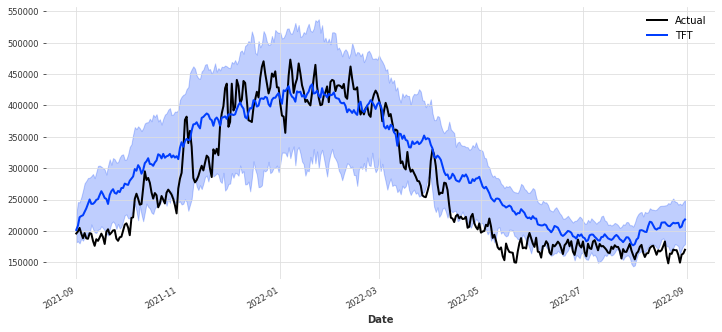

In [11]:
plt.figure(101, figsize=(12, 5))
test_unsc[-365:].plot(label='Actual')
pred_tft.plot(label='TFT')
tft_mae = mae(test_unsc[-365:], pred_tft)
tft_mape = mape(test_unsc[-365:], pred_tft)
print(f'MAE: {tft_mae}')
print(f'MAPE: {tft_mape}')